<a href="https://colab.research.google.com/github/DaniilAszn/ML2_course/blob/main/6_%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%84%D0%BE%D1%80%D0%BC%D0%B5%D1%80%D0%B0_(%D1%87%D0%B0%D1%81%D1%82%D0%B8_%D1%81_%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D0%BE%D0%BC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6 практика по NN by RTU MIREA**

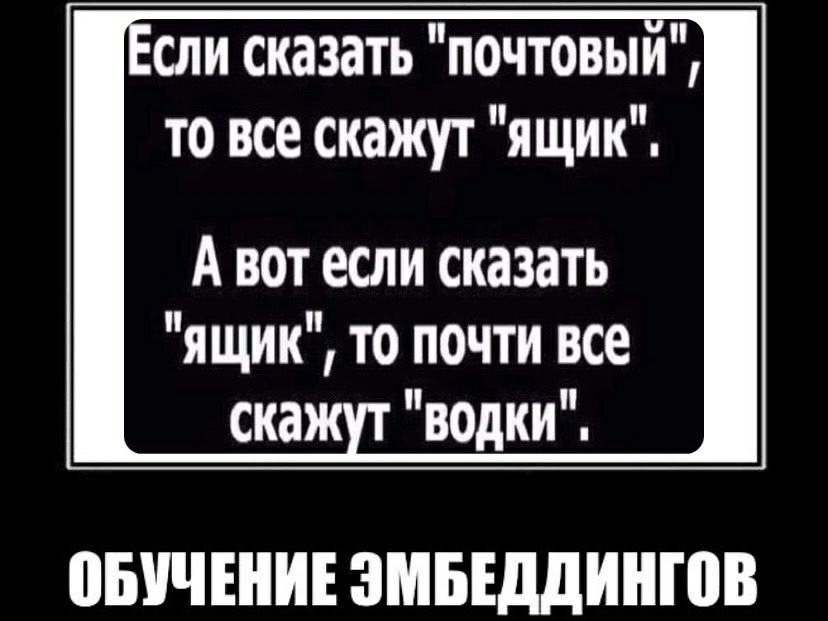

## Шаг 0: Подгрузка датасета.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import tqdm

plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')

In [ ]:
!pip install torchdata

Торч отказался делиться с данными, поэтому обратился к Керасу.

In [ ]:
from keras.datasets import imdb

Ниже предствален код, который ещё и нужным образом всё делает перед работой с текстом.

In [ ]:
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data()

# Получение словаря, сопоставляющего слова с уникальными индексами
word_index = imdb.get_word_index()

# Задание специальных символов
start_char = 1  # Символ, обозначающий начало последовательности
oov_char = 2    # Символ для слов, которые не включены в словарь ('out of vocabulary')
index_from = 3  # Смещение индекса для реальных слов, чтобы освободить место для специальных символов

# Создание словаря, чтобы можно было по индексу найти слово,
# прибавляется 'index_from' к каждому индексу для учета специальных символов
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)

# Добавление специальных символов в словарь
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"

# Преобразование обучающего и тестового набора данных из последовательности индексов в последовательность слов
train_set = np.array([" ".join(inverted_word_index[i] for i in item) for item in training_data])
test_set = np.array([" ".join(inverted_word_index[i] for i in item) for item in testing_data])

Пример текста.

In [ ]:
train_set[101]

'[START] whoever wrote up redline as a great car movie must be getting paid off by daniel sadek to promote this ultra crappy flaming steaming pile of amateur crap easily the worst automotive movie or any movie ever made this makes showgirls look like citizen kane br br take every cheesy cliché out of an 80s action tv series put in some really crappy special effects and lame characters with no relevance and you have living proof that daniel sadek should not write screenplays and produce movies but should remain in the real estate business br br this is such a lame movie with such a lame plot and the most contrived action sequences ever what offends me is not that the makers of this film are idiots but that they consider the movie going public to be idiots enough to fall for this crap'

Метка текста.

In [ ]:
training_targets[101]

0

## Шаг 1: Построение трансформера.

### Создание словаря. Токенизация.

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

# Определяем функцию итератора для текстового датасета
def dataset_iterator(texts):
    for text in texts:
        # Делим текст на токены
        yield text.split()

In [ ]:
# Создаём словарь вокабуляра из обучающего набора данных,
# добавляя специальные токены и устанавливая минимальную частоту токена
vocab = build_vocab_from_iterator(
    dataset_iterator(train_set),
    specials=['<pad>', '<unk>'], min_freq=10,
)

In [ ]:
# Создание списка токенизированных текстов для обучающего набора
train_tokens = []
for text in dataset_iterator(train_set):
    # Преобразуем каждое слово в тексте в его индекс в словаре; если слова нет, используем <unk>
    tokens = [vocab[word] if word in vocab else vocab['<unk>'] for word in text]
    train_tokens += [tokens]

# Аналогично для тестового набора данных
test_tokens = []
for text in dataset_iterator(test_set):
    tokens = [vocab[word] if word in vocab else vocab['<unk>'] for word in text]
    test_tokens += [tokens]

In [ ]:
train_tokens[101][:10]

[30, 2503, 1041, 55, 19203, 15, 4, 87, 518, 18]

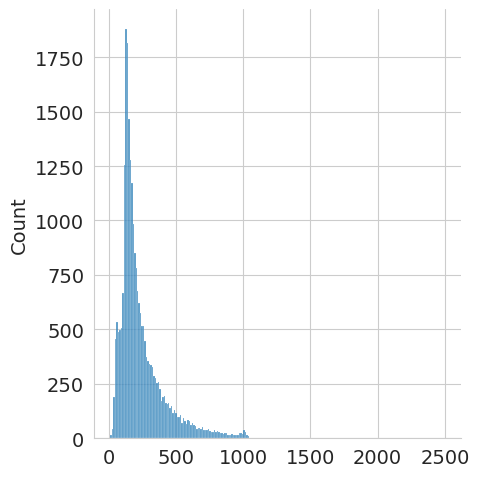

In [ ]:
# Количество текстов с определённой длинной
lengths = np.array([len(tokens) for tokens in train_tokens])
sns.displot(lengths)
plt.show()

In [ ]:
max_length = 256

# Инициализация тензоров токенизированных текстов для обучения с использованием паддинга
tokenized_train = torch.full((len(train_tokens), max_length), vocab['<pad>'], dtype=torch.int32)
for i, tokens in enumerate(train_tokens):
    # Копируем токены в тензор, обрезая или добавляя паддинг при необходимости
    length = min(max_length, len(tokens))
    tokenized_train[i, :length] = torch.tensor(tokens[:length])

# То же самое для тестового набора данных
tokenized_test = torch.full((len(test_tokens), max_length), vocab['<pad>'], dtype=torch.int32)
for i, tokens in enumerate(test_tokens):
    length = min(max_length, len(tokens))
    tokenized_test[i, :length] = torch.tensor(tokens[:length])

In [ ]:
# Создание тензоров целевых переменных для обучения и теста
targets_train = torch.tensor(training_targets, dtype=torch.int32)
targets_test = torch.tensor(testing_targets, dtype=torch.int32)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Создание датасетов для обучающего и тестового наборов данных
train_dataset = TensorDataset(tokenized_train, targets_train)
test_dataset = TensorDataset(tokenized_test, targets_test)

# Определение размера пакетов и создание загрузчиков данных
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2, pin_memory=True)

### Сборка трансформера (часть с кодером).

<center>

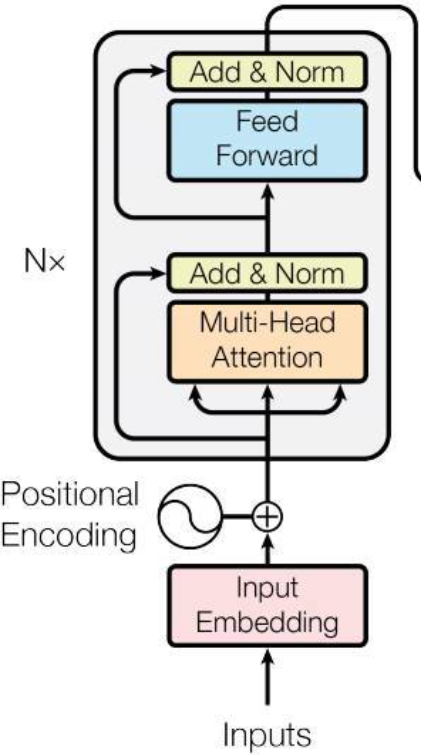

</center>

**Positional Encoding**.

Позиционное кодирование используется для ввода информации о положении каждого токена во входную последовательность. Он использует функции синуса и косинуса разных частот для генерации позиционного кодирования.

Positional Encoding позволяет модели учитывать порядок слов (или более общо, порядок элементов в последовательности), добавляя к входным данным вектор, который содержит информацию о позиции элемента в последовательности. Эта информация о позиции позволяет слою внимания в трансформере определять, насколько важен каждый элемент входной последовательности относительно остальных при формировании выходной последовательности.

In [ ]:
import math
from torch import nn

class PositionalEncoder(nn.Module):
    def __init__(self, max_length, embed_dim, dropout):
        super().__init__()
        # Создаем тензор для хранения позиционных признаков с размером [max_length, embed_dim]
        self.pos_features = torch.zeros(max_length, embed_dim) # признаки для кодирования позиций (пока нет)

        # Расчет позиций для каждого измерения
        # Создаем тензор размером [max_length, 1], содержащий последовательность от 0 до max_length-1
        positions = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)

        # Расчет частот для позиционного кодирования
        # Расчет геометрической последовательности для частоты позиционных энкодеров
        freqs = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float) * (-math.log(10000) / embed_dim)).unsqueeze(0)

        # заполнение синусами/косинусами
        arguments = positions * freqs # Вычисление аргументов для синуса и косинуса

        # Заполнение позиционных признаков:
        # Синус для четных индексов
        self.pos_features[:, 0::2] = torch.sin(arguments)
        # Косинус для нечетных индексов
        self.pos_features[:, 1::2] = torch.cos(arguments)
        # Добавляем батч измерение
        self.pos_features = self.pos_features.unsqueeze(0)

        # Преобразовываем pos_features в параметр модели, но градиенты не юзаем
        self.pos_features = nn.Parameter(self.pos_features, requires_grad=False)

        # Создаем слой Dropout для регуляризации
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        # Добавляем позиционные признаки к входным данным
        outputs = inputs + self.pos_features[:, :inputs.shape[1]]

        # Применяем Dropout и возвращаем результат
        return self.dropout(outputs)

На следующем изображении каждая строка соответствует вектору позиционного кодирования: так, первая строка будет вектором, который мы добавляем к эмбеддингу первого слова во входной последовательности, вторая строка — к эмбеддингу второго слова и т.д. Каждая строка содержит 512 значений от -1 до 1. Мы перенесли эти значения в цвета, чтобы шаблон был более нагляден.

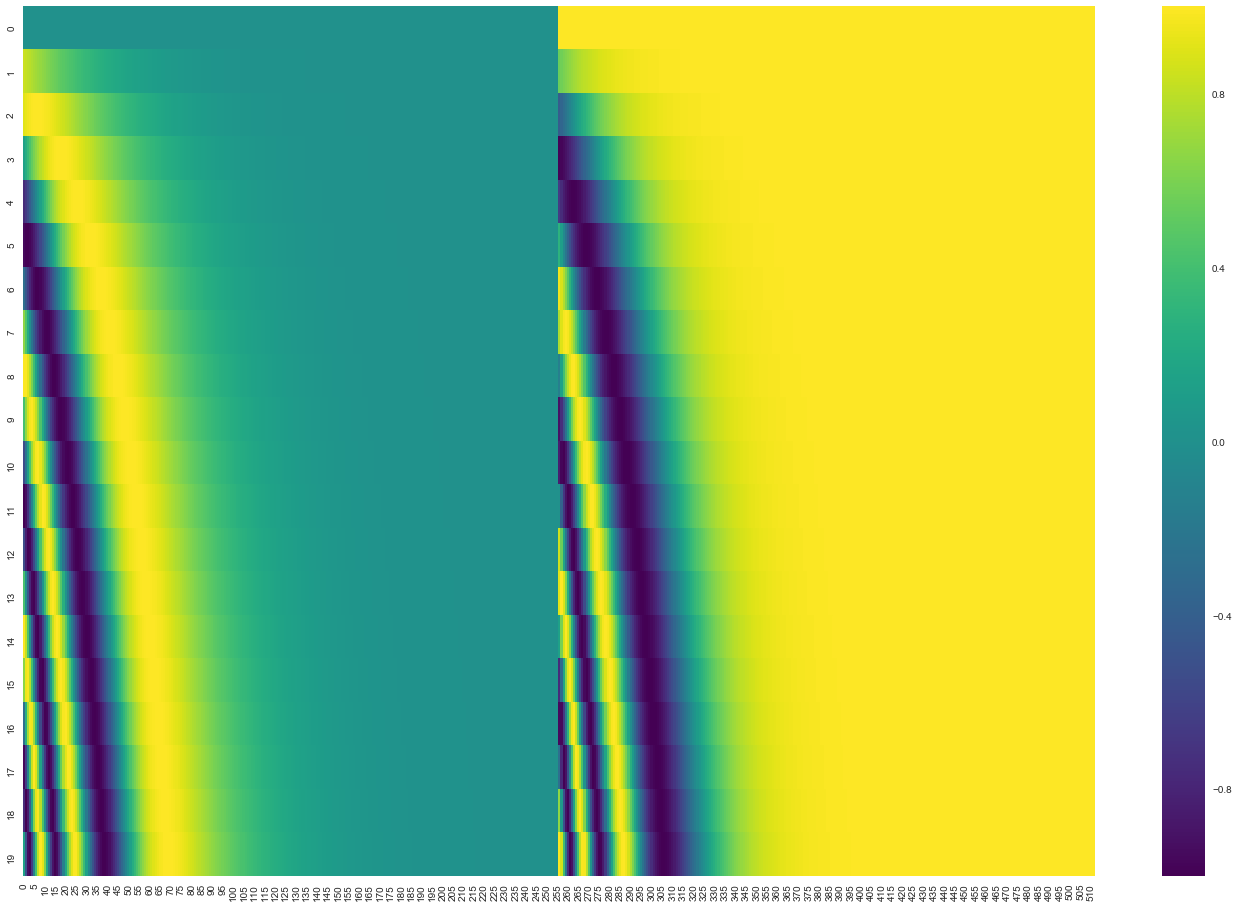

Ось Х: длина текста

ось У: размерность эмбеда

**Attention & Multi-head Attention**.

*Attention (Внимание).*

Механизм внимания в контексте трансформеров — это техника, позволяющая модели выделить наиболее значимые части входных данных относительно каждого элемента этих входных данных. В его основе лежит расчет весов внимания, которые определяют степень "внимания", или акцента, которую модель уделяет данным при подготовке выходного сигнала.

*Скалярное произведение внимания.*

Одна из популярных форм внимания — внимание на основе скалярного произведения (Scaled Dot-Product Attention). Оно вычисляется по формуле:
$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$,
где $Q, K и V$ — это запросы (queries), ключи (keys) и значения (values) соответственно, а $d_k$ — размерность ключей. Скалирование выполняется для стабилизации градиентов при больших значениях глубины.

![](https://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)

*Про Q, K, V:*
1. \(Q\) Запросы (Queries): представляют собой набор векторов, которые используются для "запроса" информации из других частей данных, т.е. какой контент следует извлечь. В контексте многоголового внимания запросы служат для проведения сравнения с ключами для определения уровня внимания, который нужно уделить каждому значению.

2. \(K\) Ключи (Keys): представляют собой вектора, которые сопоставляются с запросами. Сравнение каждого запроса с ключами позволяет определить, насколько каждый элемент данных (значение) важен для данного запроса. По сути, ключи помогают модели определить, на что "обратить внимание" при вычислении выходных данных.

3. \(V\) Значения (Values): это вектора, которые содержат сами данные, которые нужно извлечь на основании полученных весов внимания. После определения степени внимания, которое каждый запрос уделяет разным ключам, значения умножаются на соответствующие веса внимания и агрегируются для формирования выходного результата механизма внимания.

*Multi-Head Attention (Многоголовое внимание).*

Идея многоголового внимания состоит в том, чтобы параллельно применять механизм внимания несколько раз с различными линейно преобразованными версиями исходных запросов, ключей и значений. Это позволяет модели одновременно фокусироваться на информации из различных подпространств признаков и интегрировать эту информацию для каждой позиции.

По сути, Multi-Head Attention позволяет модели "посматривать" на входные данные под разными углами, что улучшает способность модели улавливать разные аспекты информации.

In [ ]:
class Attention(nn.Module):
    # Single-head attention
    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()
        # Размерность каждого вектора внимания после разбиения на "головы"
        attention_dim = embed_dim // num_heads

        # Определение линейных слоёв для преобразования входных query, key и value
        self.WQ = nn.Linear(embed_dim, attention_dim, bias=False)
        self.WK = nn.Linear(embed_dim, attention_dim, bias=False)
        self.WV = nn.Linear(embed_dim, attention_dim, bias=False)

        # Слой применения Dropout для регуляризации
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        # Предполагается, что query, key, value имеют размерности (batch_size, length, embed_dim)
        # mask имеет размерность (batch_size, length, length) и используется для "скрытия" некоторых значений

        Q = self.WQ(query)
        K = self.WK(key)
        V = self.WV(value)
        # Q, K, V: (batch_size, length, attention_dim)

        # Нормировочная константа
        norm_factor = math.sqrt(Q.shape[-1])

        # Вычисление скалярных произведений между запросами и ключами, нормализованных нормализующим множителем
        dot_products = torch.bmm(Q, K.transpose(1, 2)) / norm_factor # находим произведения для каждого батча
        # размерность dot_products: (batch_size, length, length)

        # Маска - чтоб делать Attention в декодере
        # Применение маски, если она предоставлена (используется для игнорирования некоторых значений)
        if mask is not None:
            dot_products = dot_products.masked_fill(mask, -math.inf)

        # Применение softmax для получения нормализованных весов внимания
        attention_score = nn.functional.softmax(dot_products, dim=-1)

        # Применение dropout к весам внимания и последующее умножение на значения
        attention = torch.bmm(self.dropout(attention_score), V)
        # attention_score: (batch_size, length, length)
        # attention: (batch_size, length, attention_dim)

        # Возвращается итоговая матрица внимания и веса внимания
        return attention, attention_score


class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super(MultiHeadAttention, self).__init__()

        # Проверяем, что размерность вектора эмбеддинга делится нацело на количество голов внимания
        assert embed_dim % num_heads == 0
        # Создаем список механизмов одноголового внимания, один для каждой головы
        self.attention_heads = nn.ModuleList([Attention(embed_dim, num_heads, dropout) for _ in range(num_heads)])
        # Линейный слой для агрегации выходов из всех голов внимания
        self.linear = nn.Linear(embed_dim, embed_dim, bias=False)
        # Добавляем слой дропаута для регуляризации
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        # Входы функции forward:
        # query, key, value: тензоры размером (batch_size, length, embed_dim)
        # mask: тензор маски размером (batch_size, length, length) запрещающий внимание к определенным элементам

        # Списки для хранения выходов от всех голов внимания
        attentions, attention_scores = [], []

        # Итерация по всем головам внимания и обработка входных данных
        for head in self.attention_heads:
            attention, attention_score = head(query, key, value, mask)
            attentions += [attention]
            attention_scores += [attention_score]

        # Конкатенация выходов от всех голов внимания
        attentions = torch.cat(attentions, dim=-1)
        # Стекирование оценок внимания для всех голов
        attention_scores = torch.stack(attention_scores, dim=-1)
        # attentions: (batch_size, length, embed_dim)
        # attention_scores: (batch_size, length, length, num_heads)


        # Применяем линейный слой и дропаут к агрегированному выходу
        outputs = self.linear(attentions)
        outputs = self.dropout(outputs)
        # outputs: (batch_size, length, embed_dim)

        return outputs, attention_scores

In [ ]:
# Создание маски для паддинга: учитываем, что тексты разной длины!
# То есть если текст какой-то небольшой длины, то мы его забиваем пустотами
def create_padding_mask(tokens, pad_idx=vocab['<pad>']):
    # tokens: (batch_size, length)
    length = tokens.shape[-1]
    padding_mask = (tokens == pad_idx)
    padding_mask = padding_mask.unsqueeze(1).repeat(1, length, 1)
    # padding_mask: (batch_size, length, length)

    return padding_mask

Его величество **Transformer**.

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, embed_dim, fc_dim, num_heads, dropout):
        super().__init__()
        # Многоголовое внимание для параллельной обработки
        self.self_attention = MultiHeadAttention(embed_dim, num_heads, dropout)
        # Полносвязная сеть для обработки после всех голов внимания
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, fc_dim),  # Увеличивает размерность
            nn.ReLU(),                     # Нелинейность
            nn.Dropout(dropout),           # Скажем НЕТ переобучению
            nn.Linear(fc_dim, embed_dim),  # Возвращает к исходной размерности
            nn.Dropout(dropout)            # Снова скажем НЕТ переобучению
        )
        # Нормализация для устойчивости обучения
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, inputs, mask):
        # Self-attention с последующим сложением входов и результатов
        attention, attention_score = self.self_attention(query=inputs, key=inputs, value=inputs, mask=mask)
        outputs = inputs + attention
        outputs = self.norm1(outputs)

        # Полносвязный слой с последующей нормализацией
        outputs = outputs + self.feedforward(outputs)
        outputs = self.norm2(outputs)

        return outputs, attention_score


class Transformer(nn.Module):
    def __init__(self, vocab_size, max_length, num_classes, embed_dim, fc_dim, num_heads, num_layers, dropout):
        super().__init__()
        self.embed_dim = embed_dim
        # Эмбеддинги для входных токенов
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # Добавление позиционной информации к эмбеддингу
        self.pos_encoder = PositionalEncoder(max_length, embed_dim, dropout)
        # Стек слоев трансформера
        self.layers = nn.ModuleList([TransformerLayer(embed_dim, fc_dim, num_heads, dropout) for _ in range(num_layers)])
        # Классификатор на выходе трансформера
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, tokens):
        # source: (batch_size, length)
        # Эмбеддинги, умноженные на sqrt(размер эмбеддинга), для скалирования
        embeds = self.embedding(tokens) * math.sqrt(self.embed_dim)
        outputs = self.pos_encoder(embeds)
        # outputs: (batch_size, length, embed_dim)

        # Создание маски для паддингов, чтобы исключить их из внимания
        padding_mask = create_padding_mask(tokens)
        attention_scores = []
        for layer in self.layers:
            # Пропускаем через все слои трансформера
            outputs, attention_score = layer(outputs, padding_mask)
            attention_scores += [attention_score]
        attention_scores = torch.stack(attention_scores, dim=-1)
        # outputs: (batch_size, length, embed_dim)
        # attentions_scores: (batch_size, length, embed_dim, num_heads, num_layers)

        # Использование маски для исключения паддингов при подсчёте среднего по всем выходам
        mask = (tokens != vocab['<pad>']).to(torch.float).detach()
        lengths = mask.sum(dim=1).detach()
        outputs = (outputs * mask.unsqueeze(2)).sum(dim=1) / lengths.unsqueeze(1)
        # outputs: (batch_size, embed_dim)

        logits = self.classifier(outputs)
        # logits: (batch_size, num_classes)

        return logits, attention_scores

## Шаг 2: Обучение и визуализация результатов.

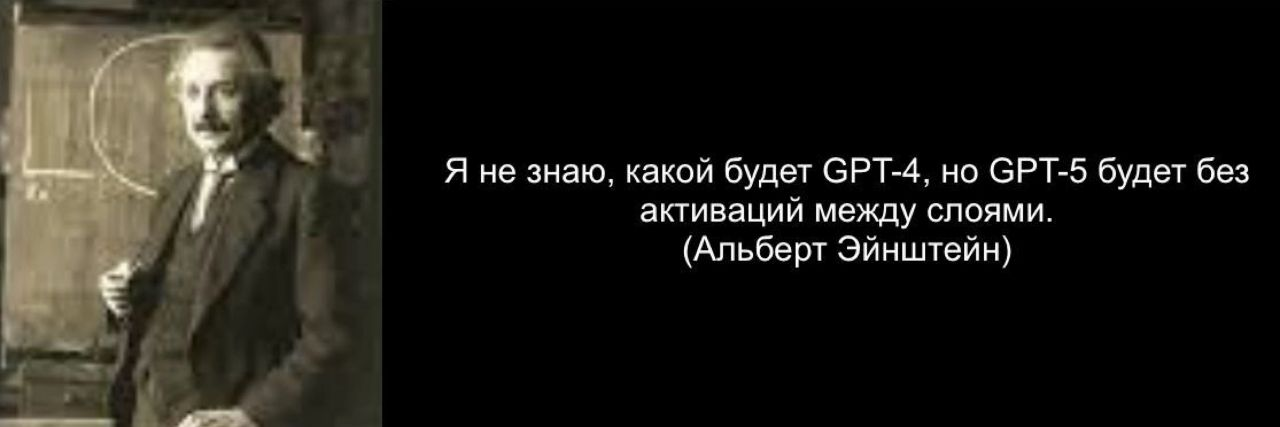

In [ ]:
from IPython.display import clear_output

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Transformer(vocab_size=len(vocab), max_length=max_length, num_classes=1, embed_dim=64, fc_dim=64, num_heads=2, num_layers=4, dropout=0.2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [ ]:
sum(param.numel() for param in model.parameters())

1434817

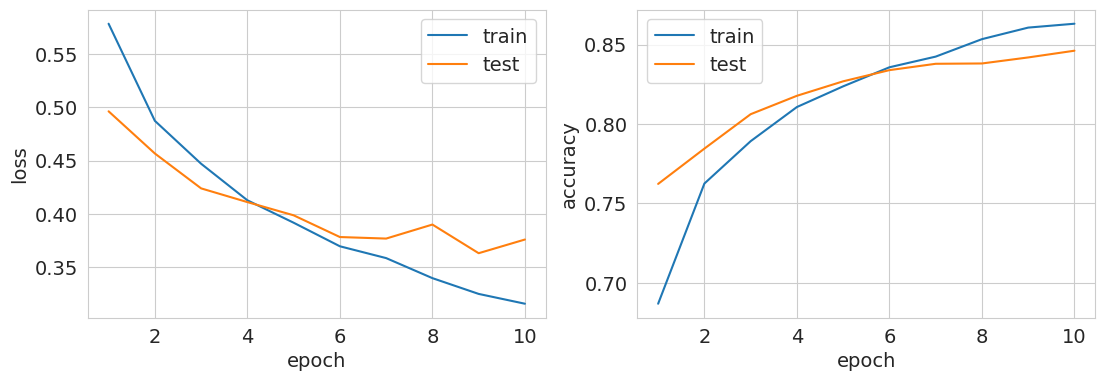

Лучший accuracy на тесте: 0.8462


In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, running_accuracy = 0.0, 0.0
    for tokens, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        tokens = tokens.to(device)
        labels = labels.to(device)

        logits, _ = model(tokens)
        probs = torch.sigmoid(logits.squeeze(1))
        loss = criterion(probs, labels.to(torch.float))
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * tokens.shape[0]
        running_accuracy += ((probs > 0.5).to(torch.int) == labels).sum().item()

    train_losses += [running_loss / len(train_loader.dataset)]
    train_accuracies += [running_accuracy / len(train_loader.dataset)]

    model.eval()
    running_loss, running_accuracy = 0.0, 0.0
    for tokens, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        tokens = tokens.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits, _ = model(tokens)
            probs = torch.sigmoid(logits.squeeze(1))
            loss = criterion(probs, labels.to(torch.float))

        running_loss += loss.item() * tokens.shape[0]
        running_accuracy += ((probs > 0.5).to(torch.int) == labels).sum().item()

    test_losses += [running_loss / len(test_loader.dataset)]
    test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

print(f'Лучший accuracy на тесте: {max(test_accuracies)}')

### Ссылки на источники:
* [Документация торча](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)
* [Хабр](https://habr.com/ru/articles/486358/)
* [Учебник Яндекса](https://education.yandex.ru/handbook/ml/article/transformery)